In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">1º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº  49718</li>
        <li>Bruno, Aluno Nº 49755</li>
    </ul>
</div>

# Indíce
1. [Indíce de Figuras](#1---Indíce-de-Figuras)
2. [Introdução](#2---Introdução)
3. [Desenvolvimento](#3---Desenvolvimento)
4. [Conclusão](#4---Conclusão)
5. [Bibliografia](#5---Bibliografia)

# 1 - Indíce de Figuras
1. [Figura 1 - _Workflow_ de uma aplicação que utilize processamento digital de visão](#fig10) 
2. [Figura 2 - Primeiros 2 segundos do vídeo de entrada](#fig1) 
3. [Figura 3 - Cálculo da imagem de fundo](#fig2) 
4. [Figura 4 - Subtração da fundo à frame](#fig3) 
5. [Figura 5 - Subtração da fundo à frame (escala de cinza)](#fig4) 
6. [Figura 6 - Binarização da imagem sem fundo](#fig5) 
7. [Figura 7 - Imagem após erosão](#fig6) 
8. [Figura 8 - Imagem após erosão e fecho](#fig7) 
9. [Figura 9 - Frame Inicial](#fig8) 
10. [Figura 10 - Frame Final](#fig9) 

# 2 - Introdução

A diabetes é uma doença crónica que afeta milhões de pessoas em todo o mundo, caracterizada por níveis elevados de glicose no sangue. O diagnóstico precoce e preciso desta condição é fundamental para prevenir complicações graves e melhorar a qualidade de vida dos pacientes.

Este trabalho utiliza o **Pima Indians Diabetes Dataset**, criado pelo National Institute of Diabetes and Digestive and Kidney Diseases (EUA), que contém informação sobre 768 mulheres da população indígena Pima, uma população com elevada incidência de diabetes. O dataset inclui 500 mulheres sem diabetes e 268 mulheres com diabetes, sendo cada observação caracterizada por 8 atributos clínicos relevantes: 
- número de gravidezes, 
- concentração de glicose plasmática, 
- pressão arterial diastólica, 
- espessura da dobra cutânea do tríceps, 
- nível sérico de insulina, 
- índice de massa corporal, 
- Diabetes Pedigree Function,
- Idade

O objetivo principal deste trabalho é desenvolver e comparar diferentes modelos de classificação binária capazes de determinar automaticamente se um paciente apresenta diabetes com base nas características fornecidas. Para tal, serão implementados e avaliados três classificadores, incluindo obrigatoriamente o Random Forest, utilizando metodologias adequadas de treino/teste e métricas apropriadas para avaliar o desempenho dos modelos.

Adicionalmente, será investigado o impacto da normalização dos dados no desempenho dos classificadores, analisando se a transformação dos dados para média nula e variância unitária contribui para melhorar a capacidade preditiva dos modelos.

O relatório apresenta uma análise dos resultados obtidos, justificando as escolhas realizadas e discutindo as decisões tomadas ao longo do desenvolvimento do trabalho.


# 3 - Desenvolvimento

Para este trabalho, foram selecionados três classificadores binários para a tarefa de classificação de diabetes. O **Random Forest Classifier** é um classificador obrigatório, baseado em ensemble de árvores de decisão. O **Support Vector Classifier (SVC)** é um algoritmo baseado em máquinas de vetores de suporte com diferentes kernels. A **Logistic Regression** é um modelo linear interpretável que utiliza a função logística.

A calibração dos hiperparâmetros será realizada através de GridSearchCV com validação cruzada (`StratifiedKFold` com 3 folds), garantindo uma exploração sistemática do espaço de hiperparâmetros e uma avaliação robusta dos modelos. Os dados serão divididos em **70% para treino+validação** e **30% para teste**, utilizando estratificação para manter a proporção de classes em ambos os conjuntos.

Para avaliar o desempenho dos classificadores, serão utilizadas várias métricas, incluindo a Matriz de Confusão, Precision, Recall e F1-Score, bem como as Curvas ROC e Precision-Recall. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting. Será também investigado o impacto da **normalização dos dados** (transformação para média nula e variância unitária) no desempenho dos classificadores, bem como a aplicação de técnicas de redução de dimensionalidade como **PCA** e **LDA**.



## 3.1 - Carregamento e Análise Inicial dos Dados

Nesta secção, procede-se ao carregamento do dataset e à análise exploratória inicial dos dados, incluindo a exploração da estrutura do dataset, distribuição de classes e estatísticas descritivas.

O dataset é um problema de **classificação binária** onde:
- **Classe 0**: Paciente **não** tem diabetes (classe negativa)
- **Classe 1**: Paciente **tem** diabetes (classe positiva)

A variável `y` contém os _labels_ das classes (0 ou 1) para cada amostra, enquanto `X` contém os dados com 8 atributos por cada paciente.


In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados
data = pickle.load(open("pimaDiabetes.p", "rb"))
X = data['data']
y = data['target']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nNúmero total de amostras: {len(y)}")
print(f"Número de features: {X.shape[1]}")
print(f"\nClasses do dataset:")
print(f"  - Classe 0 (sem diabetes): {np.sum(y==0)} amostras ({ np.round(np.sum(y==0)/len(y)*100) }%)")
print(f"  - Classe 1 (com diabetes): {np.sum(y==1)} amostras ({ np.round(np.sum(y==1)/len(y)*100) }%)")


Shape de X (features): (768, 8)
Shape de y (target): (768,)

Número total de amostras: 768
Número de features: 8

Classes do dataset:
  - Classe 0 (sem diabetes): 500 amostras (65.0%)
  - Classe 1 (com diabetes): 268 amostras (35.0%)


O dataset apresenta um desequilíbrio entre as classes (65% vs 35%), com aproximadamente 1.87 vezes mais amostras da classe 0 (sem diabetes) do que da classe 1 (com diabetes).

Este desequilíbrio justifica o uso de **estratificação** na divisão dos dados e na validação cruzada, garantindo que a proporção de classes seja mantida em todos os conjuntos (treino, validação e teste). Esta abordagem é essencial para obter uma avaliação fidedigna do desempenho dos classificadores, especialmente na detecção da classe minoritária (diabetes).


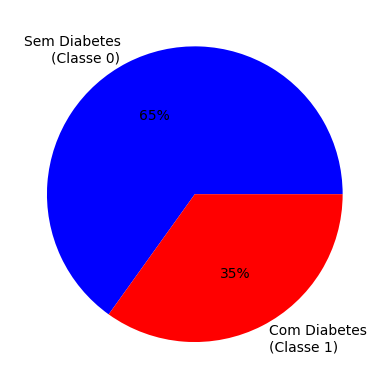

In [6]:
# Dados
classes = ['Sem Diabetes\n(Classe 0)', 'Com Diabetes\n(Classe 1)']
counts = [np.sum(y==0), np.sum(y==1)]
colors = ['blue', 'red']
# Gráfico de pizza
plt.pie(counts, labels=classes, colors=colors, autopct='%1.0f%%')

plt.show()

### 3.1.2 - Conclusões da Análise Inicial

Com base na análise exploratória realizada, podem-se tirar várias conclusões importantes. O dataset apresenta um desequilíbrio entre as classes (500 vs 268 amostras), o que justifica o uso de estratificação na validação cruzada para garantir uma avaliação real do desempenho dos classificadores.

As visualizações realizadas mostram diferenças nas distribuições das features entre as classes, indicando que as features contêm informação discriminativa útil para a classificação. Esta observação é positiva, pois sugere que os atributos potencial para distinguir entre pacientes com e sem diabetes.

Dado o contexto anterior, será necessário investigar o impacto da normalização (*StandardScaler*) no desempenho dos classificadores, especialmente para SVC e Logistic Regression, que são algoritmos sensíveis à escala dos dados. Esta estratégia de pré-processamento poderá melhorar significativamente o desempenho destes modelos.


## 3.2 - Treino de Classificadores

Nesta secção vamos então treinar e avaliar três classificadores binários: `SVC`, `Random Forest Classifier` e `Logistic Regression`. 

Para a divisão dos dados, vamos dividir em 70% para treino e validação e 30% para teste, com estratificação para manter a proporção de classes em ambos os conjuntos. Esta divisão resulta 512 amostras para treino/validação e 256 amostras para teste, garantindo um conjunto de teste suficientemente grande para uma avaliação robusta.

A calibração dos hiperparâmetros de cada modelo será feita utilizando `GridSearchCV` com validação cruzada estratificada (_StratifiedKFold_ com 3 _folds_). Esta abordagem permite-nos encontrar o melhor conjunto de hiperparametros.

Adicionalmente, para cada classificador, iremos também encontrar o melhor limiar de decisão utilizando validação cruzada. Em vez de usar o limiar de omissão, vamos testar múltiplos limiares (entre 0 e 1) para encontrar aquele que obtém a melhor taxa de verdadeiros positivos verdadeiros, e minimiza os falsos positivos. Para isso, vamos usar a métrica `F1-Score`, que combina as métricas de `precision` e `recall` num únici valor. O limiar usado pelo `scikit-learn` nos modelos de classificação binária é 0.5, que pode não ser o mais adequado para os dados que estamos a avaliar.

Esta otimização é realizada usando `cross_val_predict`, que treina modelos em cada _fold_ e prevê nas amostras de validação. O limiar otimizado é então aplicado ao conjunto de teste para avaliação final. Por omissão, 

### 3.2.1 Métricas de Avaliação

Para avaliar o desempenho dos classificadores, utilizamos várias métricas complementares:

Matriz de Confusão: Tabela que resume as previsões do modelo, mostrando os Verdadeiros Positivos (TP), Verdadeiros Negativos (TN), Falsos Positivos (FP) e Falsos Negativos (FN). Esta matriz permite visualizar rapidamente onde o modelo está a acertar e a errar, sendo especialmente útil para identificar se o modelo está a confundir mais frequentemente a classe positiva com a negativa ou vice-versa.

- _Precision_: É uma métrica que ajuda a perceber se o modelo está a acertar corretamente na classificação das classes. É calculada como $\frac{TP}{TP+FP}$. Uma precisão alta indica que quando o modelo prevê diabetes, é provável que esteja correto. Esta métrica é importante quando o custo de um falso positivo é elevado (diagnosticar diabetes quando não existe).

- _Recall_: Esta métrica ajuda a perceber se o modelo consegue detetar todos os casos positivo. É calculada como  $\frac{TP}{TP+FN}$. Um _recall_ alto indica que o modelo consegue detetar a maioria dos casos de diabetes. Esta métrica é importante em problemas de classificação em que falsos negativos podem ter consequencias ao nivel do tratamento(deteção de diabetes quando o paciente não tem diabetes).

- _F1-Score_: É uma métrica que combina as métricas precision e recall, calculada como 2 × (Precision × Recall) / (Precision + Recall). É calculada como $2 \times \frac{precision \times recall }{precision + recall }$.  Esta métrica dá mais importancia a valores baixos, e se a precision e o recall tiverem baixos indica que o nosso modelo não está a dar os melhores resultados.

- _Curva ROC_: Gráfico que mostra a relação entre e o Recall e Falsos Positivos (FP) para vários limiares. A área sob a curva ROC (AUC) varia entre 0 e 1, onde valores próximos de 1 indicam melhor capacidade discriminativa do modelo. Esta curva permite-nos o desempenho de vários limiares, e perceber se o limiar usado é o melhor ou não.

_Curva Precision-Recall_: Gráfico que mostra a relação entre precision e recall para vários limiares. Esta curva foca-se no desempenho da classe positiva (diabetes), ao contrário da curva ROC que nos dá uma visão geral de como os vários limiares se comportam na classificação.

A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível `overfitting` e garantir a capacidade de generalização dos modelos.

In [155]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=1/3,stratify=y)
cv = StratifiedKFold(n_splits=3) # para o grid search mais tarde

In [173]:
# Funções utilitárias para os classificadores

# Plota duas matrizes de confusão lado a lado (treino e teste).
def plot_confusion_matrices(cm_train, cm_test, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))
    
    # Treino
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix} - Treino')
    
    # Teste
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix} - Teste')
    
    plt.tight_layout()
    plt.show()

# Plota curva ROC (suporta plots fora e dentro de subplots)
def plot_roc_curve(fpr, tpr, roc_auc, threshold_point, model_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.plot(fpr, tpr, color='blue', label='Curva ROC')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Curva ROC - {model_name}')
    ax.legend()
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()

def plot_precision_recall_curve(recall_vals, precision_vals, threshold_point, model_name, ax=None):
    ax.plot(recall_vals, precision_vals, color='green', label='Curva Precision-Recall')
    
    ax.scatter(threshold_point[0], threshold_point[1], color='red', label='Limiar',)
  
        
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Curva Precision-Recall - {model_name}')
    ax.legend()
    ax.grid(True)
    
    if ax is None:
        plt.tight_layout()
        plt.show()

def find_threshold(model, X_train, y_train, cv, param_grid=None):
    # Obter probabilidades previstas usando validação cruzada
    model.set_params(**param_grid) # aplicar parametros ao modelo
    
    y_train_proba_cv = cross_val_predict(
        model,
        X_train, 
        y_train,
        cv=cv,
        method='predict_proba'
    )[:, 1]
    
    # Testar diferentes limiares (de 0,1, 50 valores)
    threshold_candidates = np.linspace(0, 1, 50)
    f1_scores = []
    
    for threshold in threshold_candidates:
        y_pred_thresh = (y_train_proba_cv >= threshold).astype(int)
        f1_scores.append(f1_score(y_train, y_pred_thresh))
    
    # Encontrar o melhor limiar
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = threshold_candidates[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]
    
    return best_threshold, best_f1, f1_scores

 # Plota todos os gráficos num subplot
def plot_threshold_analysis(fpr, tpr, roc_auc, recall_vals, precision_vals, cm_threshold, threshold_point_roc, threshold_point_pr, model_name=''):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    plot_roc_curve(fpr, tpr, roc_auc, threshold_point_roc, model_name, ax=axes[0])
    plot_precision_recall_curve(recall_vals, precision_vals, threshold_point_pr, model_name, ax=axes[1])
    
    # Matriz de confusão com limiar otimizado    
    disp_threshold = ConfusionMatrixDisplay(cm_threshold)    
    disp_threshold.plot(ax=axes[2], cmap='Blues')    
    axes[2].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

### 3.2.1 - SVC (Alice)


In [196]:
# Definir os hiperparâmetros
# https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running

def calibrate_svc(param_grid_svc, X_dataset,y_dataset):
    grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, cache_size=1000), # aumentar o cache size
        param_grid=param_grid_svc,
        cv=cv,
        n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
    )

    # Treinar o modelo com GridSearchCV
    grid_search_svc.fit(X_dataset, y_dataset)  
    print(grid_search_svc.best_params_)

    # Usar o melhor modelo encontrado
    return grid_search_svc.best_estimator_

# Final params
# param_grid_svc = {
#    'C': [0.5, 1, 5,  10, 20, 100, 200, 400],
#    'kernel': ['linear', 'rbf', 'sigmoid'],
#    'gamma': ['scale', 'auto', 0.1, 1, 10, 100, 200],
#    'degree': [2, 3, 4, 5]
#}
param_grid_svc = {
    'kernel': ['linear', 'sigmoid'],
}

X_train_scaled = np.ascontiguousarray(X_train_val, dtype=np.float64)
svc_calibrated = calibrate_svc(param_grid_svc,X_train_scaled,y_train_val)



{'kernel': 'linear'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       333
           1       0.76      0.60      0.67       179

    accuracy                           0.79       512
   macro avg       0.78      0.75      0.76       512
weighted avg       0.79      0.79      0.79       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       167
           1       0.65      0.48      0.55        89

    accuracy                           0.73       256
   macro avg       0.70      0.67      0.68       256
weighted avg       0.72      0.73      0.72       256



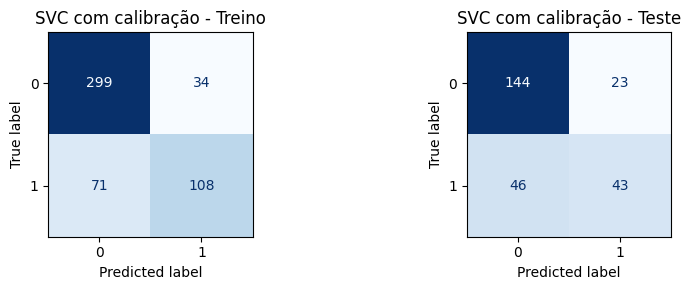

In [200]:
# Previsões no conjunto de treino

def predict_svc(svc_model, X_train_val,y_train_val,X_test,y_test ):
    y_train_pred_cal = svc_model.predict(X_train_val)
    print("\nDesempenho no conjunto de Treino")
    print(classification_report(y_train_val, y_train_pred_cal))
    cm_train_cal = confusion_matrix(y_train_val, y_train_pred_cal)

    # Previsões no conjunto de teste
    y_test_pred_cal = svc_model.predict(X_test)
    print("\nDesempenho no conjunto de Teste")
    print(classification_report(y_test, y_test_pred_cal))
    cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

    # Plotar matrizes de confusão usando a função
    plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC com calibração')
    
    
predict_svc(svc_calibrated, X_train_val,y_train_val,X_test,y_test)

Limiar (validação cruzada): 0.3061224489795918
F1-Score com limiar: 0.6855791962174941

Desempenho com limiar (0.3061224489795918):
              precision    recall  f1-score   support

           0       0.86      0.71      0.77       167
           1       0.58      0.78      0.67        89

    accuracy                           0.73       256
   macro avg       0.72      0.74      0.72       256
weighted avg       0.76      0.73      0.74       256



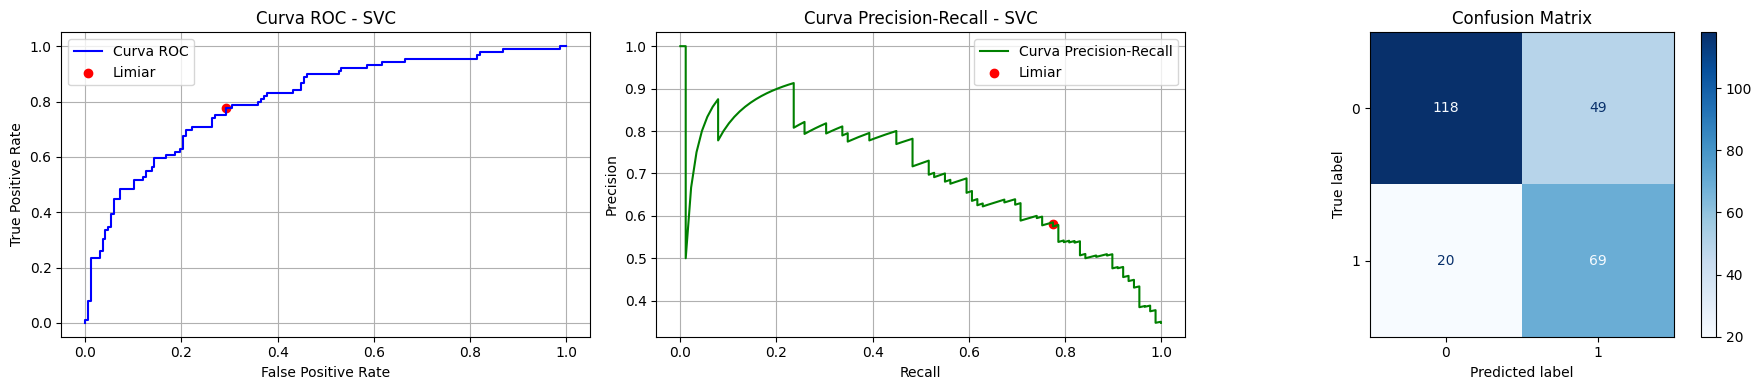

In [ ]:
# Encontrar o limiar ótimo usando validação cruzada
best_threshold_f1, best_cv_f1, f1_scores = find_threshold(
    SVC(probability=True, random_state=42),
    X_train_val,
    y_train_val,
    cv,
    param_grid=svc_calibrated
)

print(f"Limiar (validação cruzada): {best_threshold_f1}")
print(f"F1-Score com limiar: {best_cv_f1}")

# Obter probabilidades no conjunto de teste e aplicar novo limiar apenas á classe positiva
y_test_proba = svc_calibrated.predict_proba(X_test)
y_test_proba = y_test_proba[:,1]
y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

print(f"\nDesempenho com limiar ({best_threshold_f1}):")
print(classification_report(y_test, y_test_pred_threshold))

# Calcular curvas para visualização
# fp -> false positive
# tp -> true positive
fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
roc_auc = auc(fp, tp)

precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# thresholds_pr - best_threshold_f1 calcula a distancia entre 2 arrays
# retorna a distancia absoluta, e nós queremos o valor minimo, que seria o limiar mais próximo, com base no f1-score
# np.argmin retorna o index do array correspondente a valor do array que tem a menor distancia
idx_closest = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

cm_test = confusion_matrix(y_test, y_test_pred_threshold)

# Calcular pontos para os gráficos com limiar otimizado
fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

plot_threshold_analysis(
    fp, tp, roc_auc,
    recall_vals, precision_vals,
    cm_test,
    (fp_threshold, tp_threshold),
    (recall_vals[idx_closest], precision_vals[idx_closest]),
    'SVC',
)

### 3.2.2 - Random Forest Classifier (Gui)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


### 3.2.3 - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


### 3.2.4 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix dos 3 (com os dados de teste)
    - Printar as curvas roc dos 3 ao mesmo tempo

## 3.3 - Pré-processamento (TODO)

- Demonstrar que os dados não estão normalizados
- falar como é que a não normalização afeta os modelos

### 3.3.1 - Standard Scaler

In [181]:
X_norm = StandardScaler().fit_transform(X)

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=1/3,stratify=y)

### 3.3.2 - Treino com Pré-Processamento - SVC (Alice)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

In [ ]:
svc_calibrated_scaled = calibrate_svc(param_grid_svc, X_train_norm, y_train_norm)

{'kernel': 'linear'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       333
           1       0.76      0.65      0.70       179

    accuracy                           0.81       512
   macro avg       0.80      0.77      0.78       512
weighted avg       0.81      0.81      0.80       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       167
           1       0.61      0.44      0.51        89

    accuracy                           0.71       256
   macro avg       0.67      0.64      0.65       256
weighted avg       0.69      0.71      0.69       256



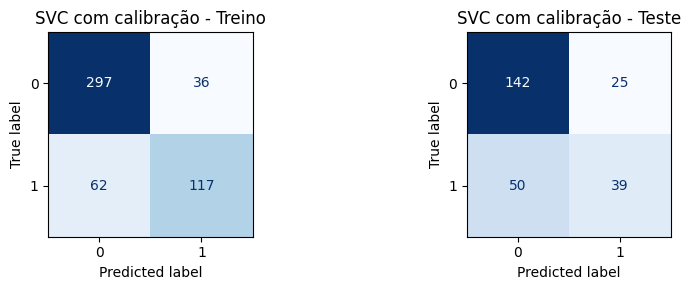

In [203]:
# Previsões no conjunto de treino
predict_svc(svc_calibrated_scaled, X_train_norm, y_train_norm, X_test_norm, y_test_norm)


### 3.3.3 - Treino com Pré-Processamento - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.4 - Treino com Pré-Processamento - Random Forest (Gui)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.5 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix
    - Printar as curvas roc dos 3 ao mesmo tempo

## 4 - Conclusões




5 - Bibliografia

- https://mariofilho.com/precisao-recall-e-f1-score-em-machine-learning/ 
- https://studyeasy.org/pt/course-articles/machine-leaning-articles-pt/auc-and-pr-curve-background-pt/#binary-classification-a-primer